In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# Pipeline params
SEED = 1
DATA_DIR = '../../data'
BASE_DATASET =  f'{DATA_DIR}/hydropower_efficiency.discretized_labels.csv'

ATTRIBUTES = [
    "altitude_m",
    "nearest_lake_dist_km",
    "days_of_rain",
    "rainfall",
    "avg_daily_temp",
    "sea_level_pressure",
    "global_radiation",
    "50m_gradient",
    "500m_gradient",
]

In [3]:
# Load and split dataset 
base_df = pd.read_csv(BASE_DATASET)
base_df.drop('plant_id', axis=1, inplace=True)
base_df.drop('type', axis=1, inplace=True)
base_df = base_df[base_df['gwh_per_mm3'] < 10] 

X, y = base_df.drop('grade', axis=1), base_df['grade']
X = X[ATTRIBUTES]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

In [4]:
# Scale features
scaler = preprocessing.MinMaxScaler()
X_train[ATTRIBUTES] = scaler.fit_transform(X_train[ATTRIBUTES])
X_val[ATTRIBUTES] = scaler.transform(X_val[ATTRIBUTES])

In [5]:
PARAMS = {
    'class_weight': ['balanced'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'n_estimators': [500],
    'min_samples_leaf': [1, 2, 4],
    'n_jobs': [3],
    'random_state': [SEED]
}

In [6]:
clf = GridSearchCV(
    RandomForestClassifier(class_weight='balanced'), 
    PARAMS,
    scoring='f1_macro'
)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                          

In [13]:
attr_scores = []
for attr, val in zip(ATTRIBUTES, clf.best_estimator_.feature_importances_):
    attr_scores.append((val, attr))
attr_scores = sorted(attr_scores, reverse=True)

In [14]:
max_score = max([p[0] for p in attr_scores])
min_score = min([p[0] for p in attr_scores])
for i in range(len(attr_scores)):
    attr_scores[i] = ((attr_scores[i][0] - min_score) / (max_score - min_score), attr_scores[i][1])

In [15]:
attr_scores

[(1.0, 'nearest_lake_dist_km'),
 (0.8279157594394546, '500m_gradient'),
 (0.6897969400505254, 'rainfall'),
 (0.6286271530263104, '50m_gradient'),
 (0.6242451159703758, 'global_radiation'),
 (0.5723615148427945, 'sea_level_pressure'),
 (0.5443476424631927, 'altitude_m'),
 (0.47631200003324264, 'avg_daily_temp'),
 (0.0, 'days_of_rain')]

In [16]:
df = pd.DataFrame.from_dict({
    'feature': [p[1] for p in attr_scores],
    'importance': [p[0] for p in attr_scores]
})

[Text(0, 0, 'nearest_lake_dist_km'),
 Text(0, 0, '500m_gradient'),
 Text(0, 0, 'rainfall'),
 Text(0, 0, '50m_gradient'),
 Text(0, 0, 'global_radiation'),
 Text(0, 0, 'sea_level_pressure'),
 Text(0, 0, 'altitude_m'),
 Text(0, 0, 'avg_daily_temp'),
 Text(0, 0, 'days_of_rain')]

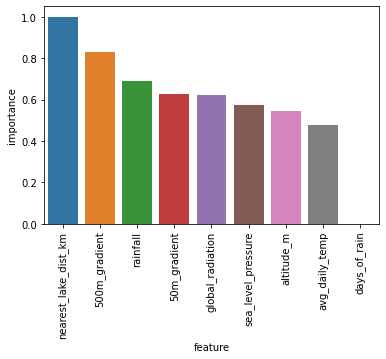

In [24]:
import seaborn as sns
ax = sns.barplot(x="feature", y="importance", data=df)
ax.set_xticklabels(rotation=90, labels=df['feature'])